In [1]:
import re

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

## Load the training data

In [2]:
df_train = pd.read_csv("data/HeadHunter_train.csv")
df_train.head()

,review_id,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target
0,0,Ижевск,Кладовщик,Недавно устроился в ****** на должность кладов...,Повысить з/п,5,4,3,3,4,4,0
1,1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (...",Упростить процессы - все процессы ради процесс...,4,4,4,1,1,1,8
2,2,Екатеринбург,Консультант,В нашем банке все по закону в плане зарплаты и...,Ничего,5,5,5,5,5,5,0
3,5,Санкт-Петербург,Оператор,Я в ****** около года работаю оператором. Норм...,Нет.,5,5,5,5,5,5,0
4,7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,4,5,4,2,5,2,8


## Training DF shape

In [3]:
df_train.shape

(50876, 12)

## Unique targets

In [4]:
unique_labels = set(df_train.target)
print(f"Unique labels num: {len(unique_labels)}")
print(f"Labels: {unique_labels}")

Unique labels num: 44
Labels: {'1,3', '1,5,6', '7', '5', '1,2,6', '3', '1,6', '1,3,6', '4,8', '5,7,8', '1,5', '4', '7,8', '5,7', '3,6', '2', '1,7,8', '3,8', '5,6,8', '3,5', '1,3,5', '6', '5,6', '1,4,6', '3,7', '1,6,8', '6,7', '4,6', '0', '8', '1,3,8', '1,5,6,8', '6,8', '1,4,8', '4,6,8', '1', '1,8', '1,4', '1,7', '3,5,7', '3,6,8', '3,5,8', '1,5,8', '5,8'}


## Targets parsing

In [5]:
target_num = np.zeros((len(df_train), 9), dtype=int)
for i, target in enumerate(df_train.target):
    indices = list(map(int, target.split(",")))
    target_num[i, indices] = 1
target_cols = list(map(lambda x: f'target_{x}', range(9)))
df_target = pd.DataFrame(
    data=target_num,
    columns=target_cols
)

df_target.head()

,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8
0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


## Replace original target with parsed

In [6]:
del df_train['target']
for col in df_target.columns:
    df_train[col] = df_target[col]

## Single targets distribution (%)

<AxesSubplot:>

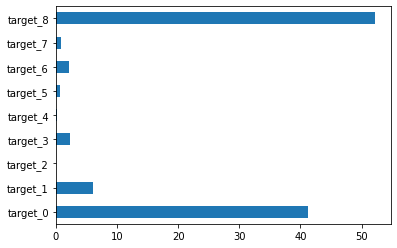

In [7]:
(df_train[target_cols].sum() / len(df_train) * 100).plot(kind='barh')

**Numeric representation (%)**

In [8]:
for col in target_cols:
    val = df_train[col].sum() / len(df_train) * 100
    print(col, val)

target_0 41.282726629452
target_1 6.126660901014231
target_2 0.02555232329585659
target_3 2.2387766333831274
target_4 0.21817752968000628
target_5 0.7390518122493906
target_6 2.101187200251592
target_7 0.7685352622061482
target_8 52.154257410173756


- Most frequent - 8  
- Most rare - 2  
- Significant fraction of reviews are passed  
- Target is strongly imbalanced

## Columns with missing values (%)

<AxesSubplot:>

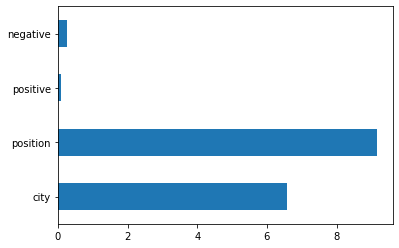

In [9]:
missing_values = df_train.isna().sum() / len(df_train) * 100
(missing_values[missing_values > 0]).plot(kind='barh')

## Number of rows after dropping NaN values

In [10]:
len(df_train.dropna())

44121

## Distribution of number of reasons for rejected reviews

<AxesSubplot:xlabel='Count'>

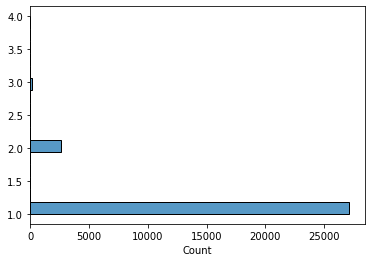

In [11]:
sns.histplot(y=df_train.loc[df_train.target_0 == 0, target_cols].sum(axis=1))

**Numeric representation**

In [12]:
df_train.loc[df_train.target_0 == 0, target_cols].sum(axis=1).value_counts()

1    27113
2     2644
3      115
4        1
dtype: int64

**Overwhelming majority of reviews are rejected because of single reason**

## Ratings

<AxesSubplot:>

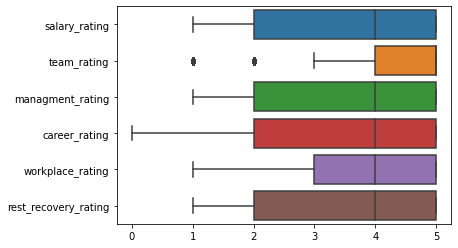

In [13]:
rating_cols = [x for x in df_train.columns if x.endswith('rating')]
sns.boxplot(data=df_train[rating_cols], orient='h')

# Cities (unique, sorted)

In [14]:
df_train.city.value_counts().sort_values(ascending=False)

Москва             23436
Санкт-Петербург     4841
Краснодар           1436
Екатеринбург         836
Нижний Новгород      782
                   ...  
Дудинка                1
Подпорожье             1
Назрань                1
Нарьян-Мар             1
Октябрьский            1
Name: city, Length: 852, dtype: int64

**Plot representation (for convenience, names are encoded with numbers)**

<AxesSubplot:xlabel='Count'>

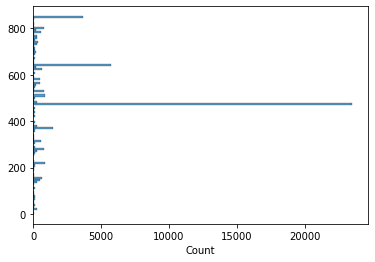

In [15]:
city_encoder = LabelEncoder()
cities_label_encoded = city_encoder.fit_transform(df_train.city)
sns.histplot(y=cities_label_encoded)

## Number of unique positions, some examples

In [16]:
positions_unique_train = sorted(list(map(str, df_train.position.unique().tolist())))
print(f"Number of unique positions: {len(positions_unique_train)}")
positions_unique_train[:30]

Number of unique positions: 12259


['"Слесарь-электрик"',
 '(кладовщик)Специалист по приему товара',
 '****** Marketing Service Director',
 '****** специалист',
 '-',
 '...',
 '.....',
 '.NET разработчик',
 '.Net Develover',
 '.Net Fullstack',
 '.юрист',
 '1. Инженер;',
 '1321',
 '1с программист',
 '1ый заместитель Директора по маркетингу',
 '23',
 '25',
 '3 Помощник Капитана Судна',
 '3 помощник капитана',
 '3D дизайнер',
 '5662',
 '????????',
 'AML compliance officer',
 'AML group (Financial sanctions) Leading officer',
 'ARGM',
 'Account Group Head',
 'Account Manager',
 'Account менеджер',
 'Accountant',
 'Accounting & Reporting specialist']

**It seems that position column is really noisy. Let's clean it**
- Lower
- Remove everything except letters and spaces
- Remove unneeded spaces
- If not empty - return result, else return "-"  

**Also missing values will be replaced by "-"**

In [17]:
def clean_text(text):
    if text == "-":
        return text
    res = str(text).lower()
    res = re.sub(r"[^ \w+]", " ", res)
    res = "".join([x for x in res if not x.isdigit()])
    res = " ".join(res.split())
    
    if not res:
        return "-"

    return res

In [18]:
df_train.position.fillna("-", inplace=True)
df_train['position_cleaned'] = df_train.position.apply(lambda x: clean_text(x))
positions_cleaned_unique_train = sorted(list(map(str, df_train.position_cleaned.unique().tolist())))
print(f"Number of unique cleaned positions: {len(positions_cleaned_unique_train)}")
positions_cleaned_unique_train[:30]

Number of unique cleaned positions: 12019


['-',
 'account group head',
 'account manager',
 'account менеджер',
 'accountant',
 'accounting reporting specialist',
 'accounts payable',
 'acting of chief engineer',
 'actuary',
 'administrative assistant',
 'administrative assurance',
 'administrator of expert resource service',
 'advanced staff',
 'advisory engineer project deputy technical director',
 'after sales project analysis specialist',
 'agile coach',
 'agile коуч',
 'american express concierge service',
 'aml compliance officer',
 'aml group financial sanctions leading officer',
 'analyst',
 'analyst in finansial department',
 'analyst in model s validation unit',
 'android developer',
 'android разработчик',
 'any',
 'architect',
 'area manager',
 'area sales manager',
 'area team lider']

**It seems there are many semantic duplicates among positions**

## Positive/negative texts
**Replace missing values and apply clean the same way as we did for positions**

In [19]:
df_train.positive.fillna("-", inplace=True)
df_train.negative.fillna("-", inplace=True)

df_train = df_train.assign(
    positive_preprocessed=df_train.positive.apply(lambda x: clean_text(x)),
    negative_preprocessed=df_train.negative.apply(lambda x: clean_text(x))
)

**Positive/negative texts lengths (in number of words)**

<AxesSubplot:>

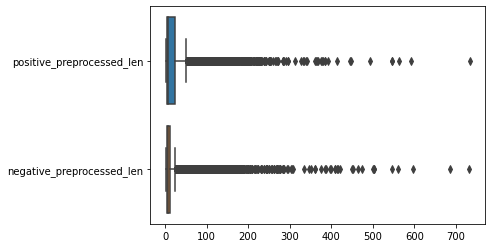

In [20]:
df_train = df_train.assign(
    positive_preprocessed_len=df_train.positive_preprocessed.apply(lambda x: len(x.split())),
    negative_preprocessed_len=df_train.negative_preprocessed.apply(lambda x: len(x.split()))
)
sns.boxplot(
    data=df_train[["positive_preprocessed_len", "negative_preprocessed_len"]],
    orient='h'
)

**Q1/median/Q3/IQR**

In [21]:
positive_median = int(df_train.positive_preprocessed_len.quantile(q=0.5))
positive_q1 = int(df_train.positive_preprocessed_len.quantile(q=0.25))
positive_q3 = int(df_train.positive_preprocessed_len.quantile(q=0.75))
positive_iqr = positive_q3 - positive_q1

negative_median = int(df_train.negative_preprocessed_len.quantile(q=0.5))
negative_q1 = int(df_train.negative_preprocessed_len.quantile(q=0.25))
negative_q3 = int(df_train.negative_preprocessed_len.quantile(q=0.75))
negative_iqr = negative_q3 - negative_q1

print(f"Positive: {positive_q1}/{positive_median}/{positive_q3}/{positive_iqr}")
print(f"Negative: {negative_q1}/{negative_median}/{negative_q3}/{negative_iqr}")

Positive: 4/7/23/19
Negative: 4/6/12/8


**Number of outliers (too long or short texts) for positive/negative texts**

In [22]:
print("Positive:")
print(f"too short={len(df_train.positive_preprocessed_len[df_train.positive_preprocessed_len <= positive_q1 - 1.5 * positive_iqr])}")
print(f"too long={len(df_train.positive_preprocessed_len[df_train.positive_preprocessed_len >= positive_q3 + 1.5 * positive_iqr])}")
print()
print("Negative:")
print(f"too short={len(df_train.negative_preprocessed_len[df_train.negative_preprocessed_len <= negative_q1 - 1.5 * negative_iqr])}")
print(f"too long={len(df_train.negative_preprocessed_len[df_train.negative_preprocessed_len >= negative_q3 + 1.5 * positive_iqr])}")

Positive:
too short=0
too long=5323

Negative:
too short=0
too long=2526


**Number of reviews that have too long positive and negative text at the same time**

In [23]:
len(df_train[
    (df_train.positive_preprocessed_len >= positive_q3 + 1.5 * positive_iqr) & 
    (df_train.negative_preprocessed_len[df_train.negative_preprocessed_len >= negative_q3 + 1.5 * positive_iqr])
])

255